# Testing Python interface to GASP

In [1]:
%matplotlib inline

In [2]:
import numpy as np  # Grids are stored as NumPy Arrays
import gasp         # GASP is what we're testing
import sys          # Needed to query size in bytes of data returned
import matplotlib.pyplot as plt

Found 1 CUDA devices in this system
Device 0 : Quadro P2000
Number of SMs       : 8
Max SHMEM per block : 48 KB
Max Opt in shared   : 48 KB
Recommended ngrids  : 1024

Estimated largest L for shared memory code path : 109
(Assumes threadsPerBlock = 32)

Using CUDA device : 0


### Run a nucleation swarm with suitable no. grids for GPU of L = 64 for upto 10000 MC sweeps

 Sweep :       9900, Reached cv =   0.90 :  727 , Unresolved :  297
CPU times: user 5.17 s, sys: 1.07 s, total: 6.24 s
Wall time: 18.3 s


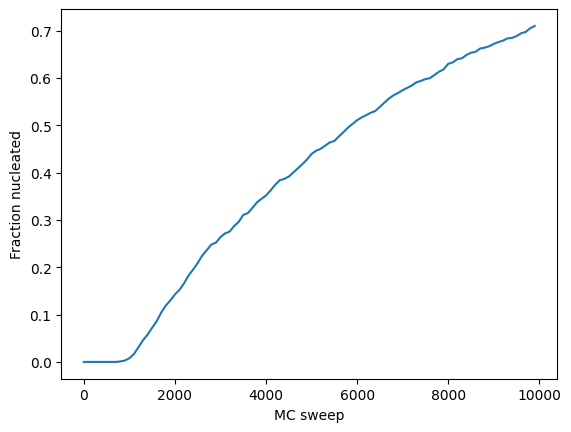

In [3]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, grid_output_int = grid_output_int, mag_output_int=mag_output_int);

sweeps = range(0, nsweeps, grid_output_int)
plt.xlabel("MC sweep")
plt.ylabel("Fraction nucleated")
plt.plot(sweeps, frac)

This will have populated `gasp.grids`, a list of snapshots, each of which is a list (one entry per grid replica) of objects with member properties inluding a 2D NumPy array representing the 2D Ising model. These arrays have type `np.int8` to save a bit of space.

**WARNING**
The contents of `gasp.grids` gets overwritten every time we run a nucleation swarm or calculate a committor. If you want to keep the contents (e.g. select a grid and pass back into GASP to compute its committor) make a deep copy.

In [4]:
# Report on grids generated
nsnaps = len(gasp.grids)
print("Number of snapshots stored     :",nsnaps)

bsize = sys.getsizeof(gasp.grids)
print("Size of gasp.grids object (MB) :", (L*L*ngrids*len(gasp.grids) + 
                                           ngrids*len(gasp.grids)*sys.getsizeof(gasp.grids[0][0]))/(1024**2))

#grid_nos = [ len(gasp.grids[i]) for i in range(nsnaps) ]
#print("ngrids at each snapshot        :",grid_nos)

print("Shape of each output grid : ", gasp.grids[4][0].grid.shape)

Number of snapshots stored     : 100
Size of gasp.grids object (MB) : 404.6875
Shape of each output grid :  (64, 64)


## Examine the output
Plot a random replica at a random snapshot. Find all snapshots for that replica which have "interesting" magnetisation and store them.

isnap =  90 igrid =  826
magnetisaion :  0.95068359375


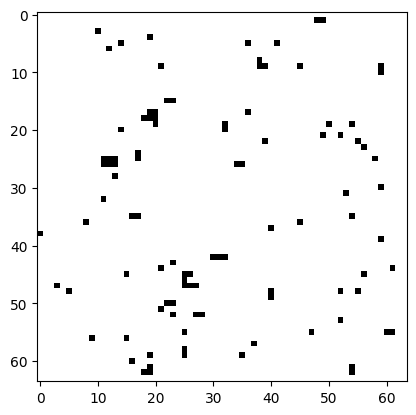

In [5]:
import matplotlib.pyplot as plt

# Visualise a random grid at a random sweep
isnap = np.random.randint(0, len(gasp.grids))
igrid = np.random.randint(0, ngrids)
grid_data = np.array(gasp.grids[isnap][igrid].grid)

plt.imshow(grid_data, cmap='grey')
print("isnap = ", isnap, "igrid = ",igrid)
print("magnetisaion : ", gasp.grids[isnap][igrid].magnetisation)

Text(0, 0.5, 'm')

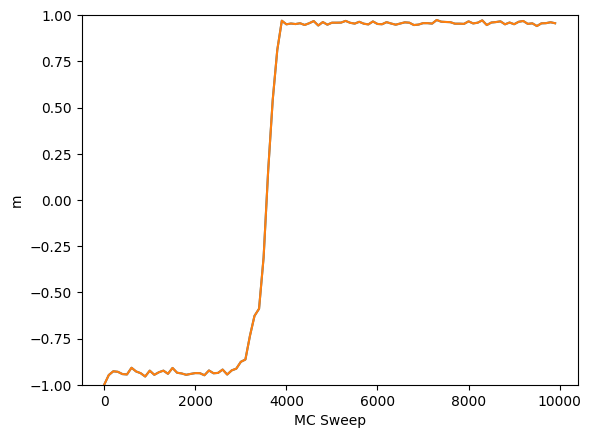

In [6]:
# Compute magnetisation vs time for grid igrid
# Also extract from gasp.magnetisation for comparison
xdata = []
ydata = []
zdata = []
for isnap, gridlist in enumerate(gasp.grids):
    xdata.append(isnap*grid_output_int)
    ydata.append(gasp.grids[isnap][igrid].magnetisation)
    zdata.append(gasp.magnetisation[isnap][igrid])

plt.plot(xdata,ydata)
plt.plot(xdata,zdata)
plt.xlabel("MC Sweep")
plt.ylim(-1,1)
plt.ylabel("m")

In [7]:
# Find the grids where the magnetisation is between -0.75 +/- 0.2
sample_grids = [ grids[igrid] for grids in gasp.grids]
sample_snaps = [ snap for snap in sample_grids if ( abs(snap.magnetisation + 0.75) < 0.2 ) ]
print("Selected ", len(sample_snaps), "snapshots from grid ", igrid)

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)

Selected  33 snapshots from grid  826


isnap =  99 igrid =  826
magnetisation :  -0.94775390625


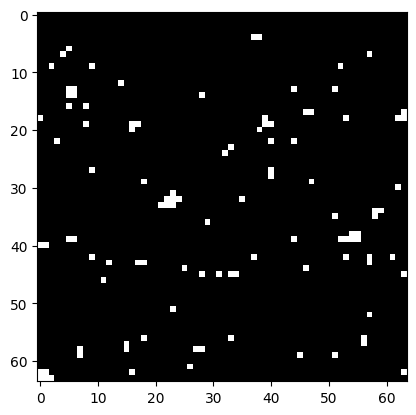

In [8]:
# Plot the first one and save it to file so we can use it again if we want
if (len(loc_sample_snaps)) > 0:
    plt.imshow(loc_sample_snaps[0].grid, cmap='grey')
    print("isnap = ", isnap, "igrid = ",igrid)
    print("magnetisation : ", loc_sample_snaps[0].magnetisation)
    np.save('sample.npy', loc_sample_snaps[0].grid)

In [9]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100000, grid_input="NumPy", grid_array=[snap.grid])
        pB.append(frac)

 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  987 , Reached cv =   0.90 :   37 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  964 , Reached cv =   0.90 :   60 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  996 , Reached cv =   0.90 :   28 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0


In [10]:
# Find the ones which are interesting (if any)
iint = [ i for i in range(len(pB)) if pB[i][0][0] > 0.0 and pB[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
pB

Found  3 interesting grids


[[(0.0, 0.0)],
 [(0.0361328125, 0.005636914527742103)],
 [(0.0, 0.0)],
 [(0.0, 0.0)],
 [(0.0, 0.0)],
 [(0.05859375, 0.007340117672466951)],
 [(0.02734375, 0.005098370278338798)],
 [(0.0, 0.0)]]

pB =  [(0.0361328125, 0.005636914527742103)]


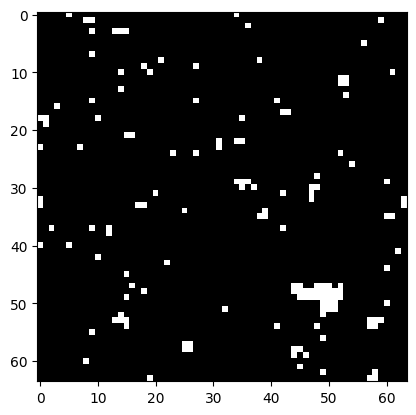

pB =  [(0.05859375, 0.007340117672466951)]


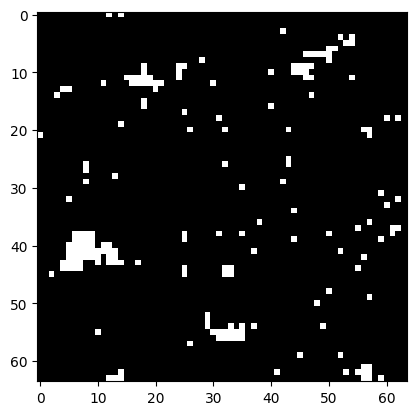

pB =  [(0.02734375, 0.005098370278338798)]


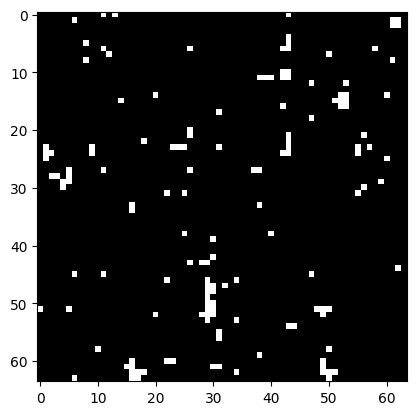

In [11]:
for i in iint:
    print("pB = ", pB[i])
    plt.imshow(loc_sample_snaps[i].grid, cmap='grey')
    plt.show()

## Compute pB for multiple snapshots at once using a fraction of the GPU for each
i.e. pass a list of NumPy arrays to `gasp.run_committor_calc`. Be careful to ensure the length of the list is such that a whole number of SMs on the GPU will be allocated to each snapshot in the list.

WARNING - this section won't do much if there aren't at least `gasp.gpu_nsms` interesting generated at based on the criteria above.

In [12]:
# For purposes of dividing up multiple committor calcs onto a single GPU, it is useful to reference the number of streaming multiprocessors
# (SMs) on the GPU we're working with. We should run a maximum of gpu_nsms x 4 grids at once on each GPU
gpu_nsms = gasp.gpu_nsms

# Calculate committor of all these snapshots using 1/gpu_nsms of a GPU for each
snapslist = [grid.grid for grid in loc_sample_snaps[0:gpu_nsms]] 
if len(snapslist)==gasp.gpu_nsms:
    print("Number of grids passed in : ",len(snapslist))
    pBfast = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist)

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

Number of grids passed in :  8
 Sweep :       1800, Reached cv =  -0.93 : 1009 , Reached cv =   0.90 :   15 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.046875 +/-  0.017121966009704035
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.0703125 +/-  0.022169713023121717
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0


In [13]:
# Calculate using twice the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//2])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:gpu_nsms])
    pBfast = pBfast1 + pBfast2

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1300, Reached cv =  -0.93 : 1017 , Reached cv =   0.90 :    7 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 : 1008 , Reached cv =   0.90 :   16 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.02734375 +/-  0.01092153090165515
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.05078125 +/-  0.01317850650545404
pB =  0.01171875 +/-  0.006769796973778759
pB =  0.0 +/-  0.0


In [14]:
# Calculate using 4x the SMs per snapshot
if len(snapslist)==gpu_nsms:
    pBfast1 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[0:gpu_nsms//4])
    pBfast2 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//4:gpu_nsms//2])
    pBfast3 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[gpu_nsms//2:3*gpu_nsms//4])
    pBfast4 = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=10000, grid_input="NumPy", grid_array=snapslist[3*gpu_nsms//4:gpu_nsms])
    pBfast = pBfast1 + pBfast2 + pBfast3 + pBfast4

for pB in pBfast:
    print("pB = ",pB[0], "+/- ", pB[1])

 Sweep :       1300, Reached cv =  -0.93 : 1008 , Reached cv =   0.90 :   16 , Unresolved :    0
 Sweep :          0, Reached cv =  -0.93 : 1024 , Reached cv =   0.90 :    0 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  993 , Reached cv =   0.90 :   31 , Unresolved :    0
 Sweep :       1200, Reached cv =  -0.93 : 1012 , Reached cv =   0.90 :   12 , Unresolved :    0
pB =  0.0 +/-  0.0
pB =  0.03125 +/-  0.007553007144542646
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.0 +/-  0.0
pB =  0.060546875 +/-  0.010601448636112926
pB =  0.0234375 +/-  0.006969358989595242
pB =  0.0 +/-  0.0


## Experiment with synthetic configurations
Create a square or a circle region of spin up and compute the committor of that configuration

 Sweep :       1700, Reached cv =  -0.93 :  223 , Reached cv =   0.90 :  801 , Unresolved :    0
pB =  [(0.7822265625, 0.012590283354376076)]


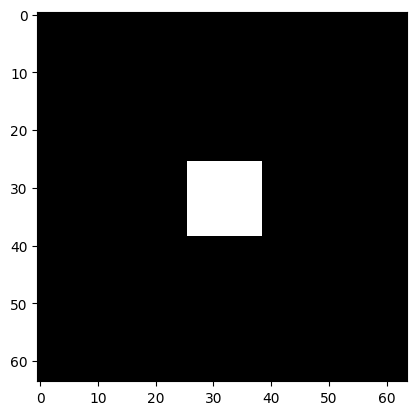

In [15]:
import math as m

# Create a synthetic grid
new_grid = np.ones((L,L),dtype=np.int8)
centre = (L/2, L/2)
size = 6

for irow in range(L):
    for icol in range(L):

        # Square
        if ( abs(irow - centre[1]) > size) or abs(icol - centre[0]) > size:
            new_grid[irow][icol] = -1
        
        # Circle
        #dist = m.sqrt( (irow - centre[1])**2 + (icol - centre[0])**2 )
        #if dist > size:
        #    new_grid[irow][icol] = -1

plt.imshow(new_grid, cmap='grey')
frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
print("pB = ", frac)

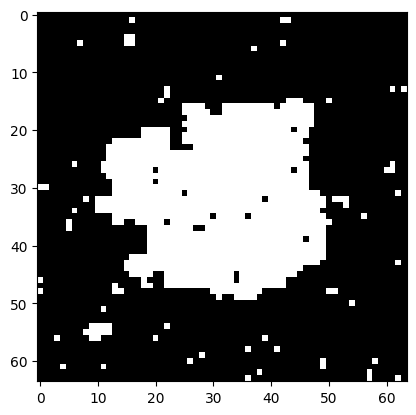

In [16]:
# Have a look at what the initial configuration evolved to after a few snapshots on a random grid
igrid = np.random.randint(0, ngrids)
plt.imshow(gasp.grids[3][242].grid,cmap='grey')

In [17]:
# Use the synthetic config to sanity check the error bar calculation. Run 10 repeats of the pB calculation
pB_repeats = []
for i in range(10):
    frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h, grid_output_int=100, grid_input="NumPy", grid_array=[new_grid])
    pB_repeats.append(frac)
pB_repeats

 Sweep :       1700, Reached cv =  -0.93 :  241 , Reached cv =   0.90 :  783 , Unresolved :    0
 Sweep :       1900, Reached cv =  -0.93 :  217 , Reached cv =   0.90 :  807 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  225 , Reached cv =   0.90 :  799 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  237 , Reached cv =   0.90 :  787 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  233 , Reached cv =   0.90 :  791 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  228 , Reached cv =   0.90 :  796 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  227 , Reached cv =   0.90 :  797 , Unresolved :    0
 Sweep :       1600, Reached cv =  -0.93 :  221 , Reached cv =   0.90 :  803 , Unresolved :    0
 Sweep :       1800, Reached cv =  -0.93 :  231 , Reached cv =   0.90 :  793 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  230 , Reached cv =   0.90 :  794 , Unresolved :    0


[[(0.7646484375, 0.012646931055308345)],
 [(0.7880859375, 0.012972148123455056)],
 [(0.7802734375, 0.01275240558306189)],
 [(0.7685546875, 0.012904595902253208)],
 [(0.7724609375, 0.012992034405472894)],
 [(0.77734375, 0.013310848349025779)],
 [(0.7783203125, 0.01308592069587189)],
 [(0.7841796875, 0.012889062144568643)],
 [(0.7744140625, 0.012964748986340877)],
 [(0.775390625, 0.013172369501360096)]]

In [18]:
# What is the standard error estimate on the average of pB over those repeats
pB_vals = np.array([ val[0][0] for val in pB_repeats ])
bf_err = np.std(pB_vals)/m.sqrt(len(pB_vals))
print("Estimate from 10 repeats : ", np.mean(pB_vals), " +/- ", bf_err) 

Estimate from 10 repeats :  0.7763671875  +/-  0.0020899350155305367


In [19]:
# A single repeat has a sample size 10 times smaller, and so from a single calculation we'd expect the error to be sqrt(10) times larger
print("Expected error from single repeat : ", bf_err*m.sqrt(len(pB_vals)))

Expected error from single repeat :  0.006608954810815871


In [20]:
# This is about what we're estimating via bootstrapping from a single calc, so all good.

## Experiment with using largest cluster size rather than magnetisation to set thresholds
We'll now need to specify the arguments `up_threshold` and `dn_threshold` since the defaults are for magnetisation.

In [21]:
%%time

L = 64
ngrids = 4*gasp.gpu_nsms*32
nsweeps = 10000
beta = 0.54
h = 0.07

grid_output_int = 100 # Should be a multiple of mag_output_int (not enforced?)
mag_output_int  = 100 # Note that the collective variable (be it magnetisation or cluster size) is computed only at this interval

frac = gasp.run_nucleation_swarm(L, ngrids, nsweeps, beta, h, 
                                 cv='largest_cluster', up_threshold=1000, dn_threshold=15, 
                                 grid_output_int = grid_output_int,
                                 mag_output_int = mag_output_int);
print("Fraction of nucleated trajectories : ", frac)

 Sweep :       9900, Reached cv = 1000.00 :  763 , Unresolved :  261
Fraction of nucleated trajectories :  [0.         0.         0.         0.00097656 0.00292969 0.00683594
 0.01464844 0.02734375 0.046875   0.06054688 0.07910156 0.09179688
 0.11132812 0.12109375 0.1328125  0.14648438 0.16210938 0.16894531
 0.18066406 0.1875     0.20214844 0.21386719 0.22558594 0.23828125
 0.24707031 0.25878906 0.2734375  0.27929688 0.2919922  0.30273438
 0.31054688 0.32714844 0.33691406 0.3408203  0.34960938 0.3623047
 0.36523438 0.37597656 0.38671875 0.3984375  0.40820312 0.4140625
 0.42089844 0.4296875  0.43652344 0.44140625 0.44628906 0.45507812
 0.4638672  0.47460938 0.48242188 0.48632812 0.49609375 0.5
 0.50878906 0.5126953  0.51953125 0.52441406 0.5292969  0.5341797
 0.5410156  0.5488281  0.55566406 0.56152344 0.5703125  0.578125
 0.5839844  0.5908203  0.5957031  0.5996094  0.60253906 0.609375
 0.6142578  0.6191406  0.625      0.6298828  0.6357422  0.6455078
 0.65234375 0.6582031  0.6660156  0.6

Text(0, 0.5, 'N')

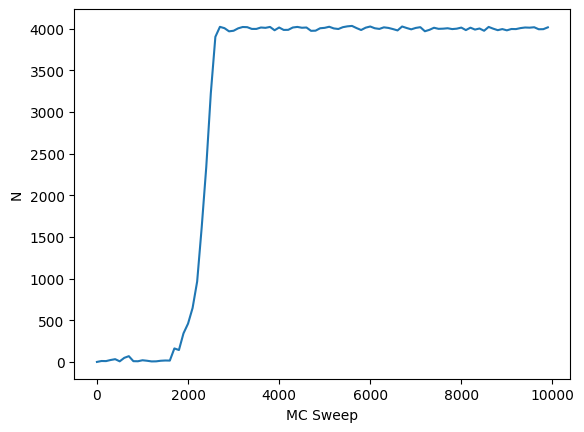

In [22]:
# Plot largest cluster size against time for some random igrid. Repeat this a few times to see how high
# an N do the non-nucleated trajectories reach before returning to low N. That helps decide where to set
# the lowest threshold for pB calcs.
igrid = np.random.randint(0, ngrids)

xdata = []
ydata = []
for isnap, gridlist in enumerate(gasp.grids):
    xdata.append(isnap*grid_output_int)
    ydata.append(gasp.largest_cluster[isnap][igrid])

plt.plot(xdata,ydata)

plt.xlabel("MC Sweep")
plt.ylabel("N")

In [23]:
# Find the snapshots where the largest cluster size is between 100 and 1000 for grid igrid
sample_grids = [ grids[igrid] for grids in gasp.grids]
lclus_grid   = [ lclus[igrid] for lclus in gasp.largest_cluster ]
lclus_snap   = [ lclus_grid[isnap] for isnap in range(len(sample_grids)) if lclus_grid[isnap] > 30 and lclus_grid[isnap] < 3000 ]
sample_snaps = [ sample_grids[isnap] for isnap in range(len(sample_grids)) if lclus_grid[isnap] > 30 and lclus_grid[isnap] < 3000 ]

print("Selected ", len(sample_snaps), " snapshots from grid ", igrid)
print("Storing  ", len(lclus_snap), " largest cluster sizes")

# Make sure we work off a copy of this as the data behind gasp.grids will be destroyed when we do a pB calc
import copy
loc_sample_snaps = copy.deepcopy(sample_snaps)
loc_lclus_snaps = copy.deepcopy(lclus_snap)

Selected  11  snapshots from grid  298
Storing   11  largest cluster sizes


In [25]:
# Calculate committor of all these snapshots
nsweeps = 50000
pB_clus = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='largest_cluster', up_threshold=3000, dn_threshold=10, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap.grid])
        pB_clus.append(frac)

 Sweep :       1900, Reached cv =  10.00 :  954 , Reached cv = 3000.00 :   70 , Unresolved :    0
 Sweep :       1900, Reached cv =  10.00 :  927 , Reached cv = 3000.00 :   97 , Unresolved :    0
 Sweep :       2000, Reached cv =  10.00 :  801 , Reached cv = 3000.00 :  223 , Unresolved :    0
 Sweep :       1800, Reached cv =  10.00 :  257 , Reached cv = 3000.00 :  767 , Unresolved :    0
 Sweep :       1800, Reached cv =  10.00 :  360 , Reached cv = 3000.00 :  664 , Unresolved :    0
 Sweep :       1100, Reached cv =  10.00 :    1 , Reached cv = 3000.00 : 1023 , Unresolved :    0
 Sweep :        800, Reached cv =  10.00 :    0 , Reached cv = 3000.00 : 1024 , Unresolved :    0
 Sweep :        700, Reached cv =  10.00 :    0 , Reached cv = 3000.00 : 1024 , Unresolved :    0


In [27]:
# Calculate committor of all these snapshots using magnetisation and compare
nsweeps = 50000
pB_mag = []

if (len(loc_sample_snaps)) > 0:
    for isnap, snap in enumerate(loc_sample_snaps):

        if (isnap == gasp.gpu_nsms): break  # While debugging, only care about enough grids to populate GPU below
        
        frac = gasp.run_committor_calc(L, ngrids, nsweeps, beta, h,
                                       cv='magnetisation', up_threshold=0.9, dn_threshold=-0.93, 
                                       grid_output_int=10000, grid_input="NumPy", grid_array=[snap.grid])
        pB_mag.append(frac)

 Sweep :       1500, Reached cv =  -0.93 :  985 , Reached cv =   0.90 :   39 , Unresolved :    0
 Sweep :       1300, Reached cv =  -0.93 :  962 , Reached cv =   0.90 :   62 , Unresolved :    0
 Sweep :       1400, Reached cv =  -0.93 :  828 , Reached cv =   0.90 :  196 , Unresolved :    0
 Sweep :       1500, Reached cv =  -0.93 :  240 , Reached cv =   0.90 :  784 , Unresolved :    0
 Sweep :       1700, Reached cv =  -0.93 :  353 , Reached cv =   0.90 :  671 , Unresolved :    0
 Sweep :       1100, Reached cv =  -0.93 :    0 , Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :       1000, Reached cv =  -0.93 :    0 , Reached cv =   0.90 : 1024 , Unresolved :    0
 Sweep :        800, Reached cv =  -0.93 :    0 , Reached cv =   0.90 : 1024 , Unresolved :    0


In [28]:
# Find the ones which are interesting (if any) based on largest cluster pB
iint = [ i for i in range(len(pB_clus)) if pB_clus[i][0][0] > 0.0 and pB_clus[i][0][0] < 1.0 ]
print("Found ", len(iint), "interesting grids")
iint

Found  6 interesting grids


[0, 1, 2, 3, 4, 5]

pB =  [(0.068359375, 0.008028014251681877)] largest cluster size =  33.0


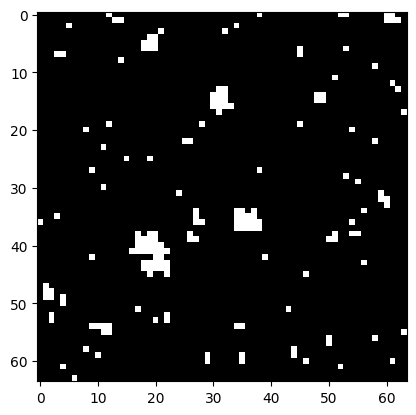

pB =  [(0.0947265625, 0.009284318009069682)] largest cluster size =  49.0


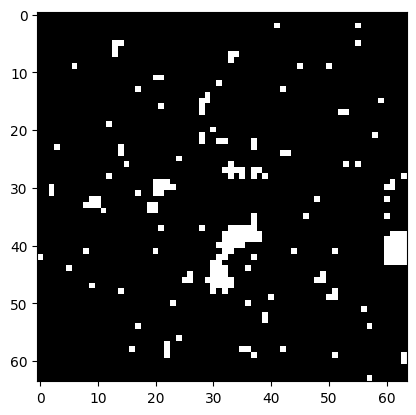

pB =  [(0.2177734375, 0.01270195578421988)] largest cluster size =  69.0


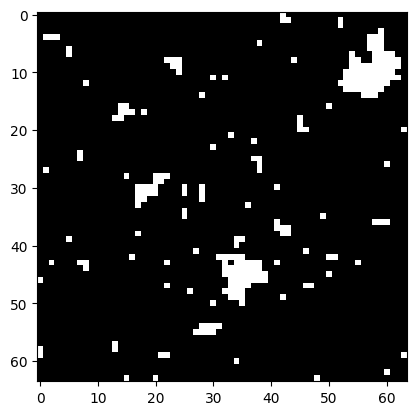

pB =  [(0.7490234375, 0.012877528529390826)] largest cluster size =  162.0


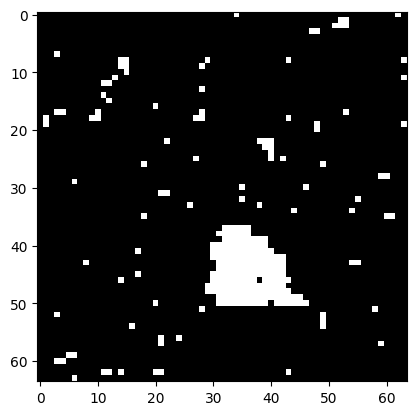

pB =  [(0.6484375, 0.015208387939335734)] largest cluster size =  143.0


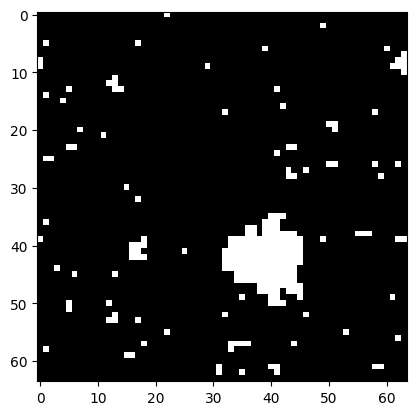

pB =  [(0.9990234375, 0.000957950541600381)] largest cluster size =  343.0


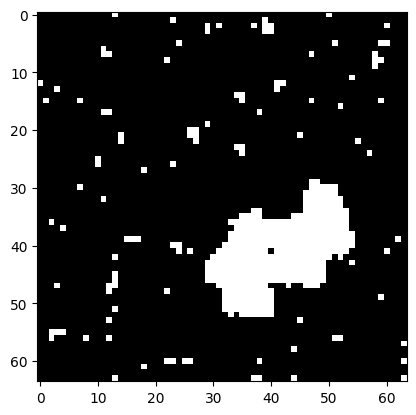

In [30]:
for i in iint:
    print("pB = ", pB_clus[i], "largest cluster size = ", loc_lclus_snaps[i], )
    plt.imshow(loc_sample_snaps[i].grid, cmap='grey')
    plt.show()